In [1]:
import clustersight as cs

In [2]:
import torch
import numpy as np
import pandas as pd

In [3]:
embeddings = torch.load('bilstm_embeddings.pt').numpy()
labels = torch.load('all_clono_labels.pt').numpy()

In [4]:
# un-one-hot encode
labels = np.argmax(labels, axis=1)

In [40]:
# create df
embeddings_cols = [f'component_{i}' for i in range(20)]
embeddings_df = pd.DataFrame(embeddings, columns=embeddings_cols)
labels_df = pd.DataFrame(labels, columns=['tcr_spec'])
df = pd.concat([embeddings_df, labels_df], axis=1)
print('Before de-dupe: ', len(df), ' entries')
print('flu: ', len(df[df['tcr_spec'] == 14]), ' entries')
# df = df.drop_duplicates()
print('flu: ', len(df[df['tcr_spec'] == 14]), ' entries')

Before de-dupe:  40500  entries
flu:  1263  entries
flu:  1263  entries


In [41]:
df['is_flu'] = df['tcr_spec'] == 14
flu_df = df[df['is_flu']]

In [7]:
# df.to_csv('embeddings_labels_df.csv', index=False)

In [26]:
len(flu_df)

508

/Users/johnboesen/Documents/Code/#Work/tcellmatch/tcell-env/lib/python3.11/site-packages/clustersight/cluster.py:191: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/johnboesen/Documents/Code/#Work/tcellmatch/tcell-env/lib/python3.11/site-packages/clustersight/cluster.py:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



    'data': [{'marker': {'color': '#EF553B'},
              'mode': 'markers',
 …

Feature Importances in Decision Tree
component_1: 71.33%
component_5: 28.67%
component_0: 0.00%
component_2: 0.00%
component_3: 0.00%
component_4: 0.00%
component_6: 0.00%
component_7: 0.00%
component_8: 0.00%
component_9: 0.00%


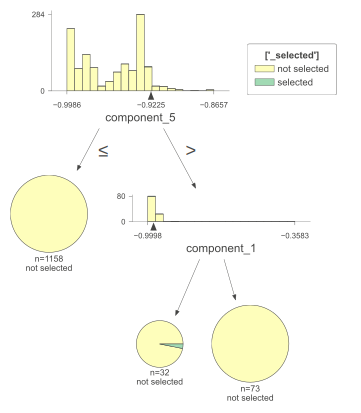

Feature Importances in Decision Tree
component_8: 88.82%
component_16: 11.16%
component_18: 0.01%
component_0: 0.00%
component_1: 0.00%
component_2: 0.00%
component_3: 0.00%
component_4: 0.00%
component_5: 0.00%
component_6: 0.00%


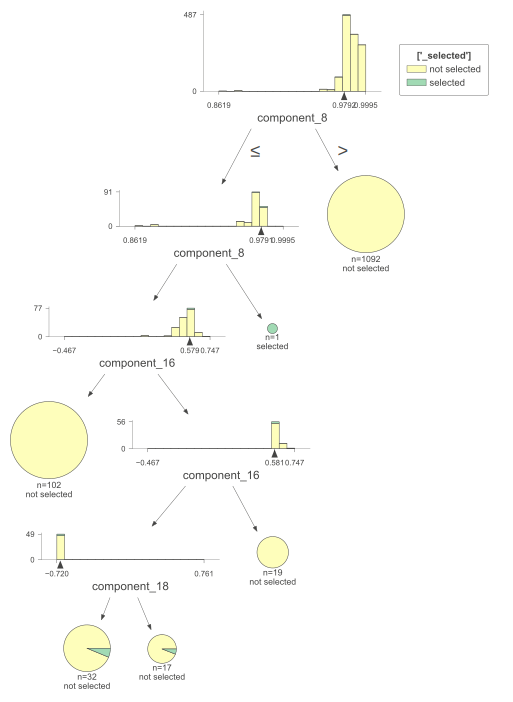

Feature Importances in Decision Tree
component_1: 71.33%
component_5: 28.67%
component_0: 0.00%
component_2: 0.00%
component_3: 0.00%
component_4: 0.00%
component_6: 0.00%
component_7: 0.00%
component_8: 0.00%
component_9: 0.00%


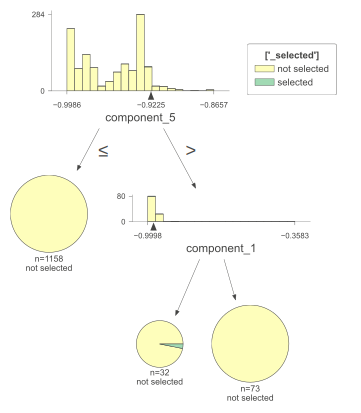

In [42]:
cs.create_lasso(flu_df, mode='explainer', label_col='is_flu', exclude_cols=['tcr_spec'], dtreeviz_plot=True, plot_name='Flu Epitope Clustering')

In [9]:
def assign_cluster(row):
    if row['is_flu']:
        if row['component_5'] <= -0.923:
            return 'flu_cluster1'
        elif row['component_5'] > -0.923 and row['component_1'] <= -0.974:
            return 'flu_cluster2'
        else:
            return 'flu_cluster3'
    else:
        return 'not_flu'

# Apply the function to each row in the dataframe
df['cluster'] = df.apply(assign_cluster, axis=1)

In [10]:
def downsample_nonflu(df, frac=0.1):
    # this makes the clustering faster
    
    false_rows = df[~df['is_flu']]

    # Downsample the selected rows to include 10% of the rows
    downsampled_df = false_rows.sample(frac=frac)

    # Combine the downsampled rows with the original rows where 'is_flu' is True
    return pd.concat([df[df['is_flu']], downsampled_df])

/Users/johnboesen/Documents/Code/#Work/tcellmatch/tcell-env/lib/python3.11/site-packages/clustersight/cluster.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/johnboesen/Documents/Code/#Work/tcellmatch/tcell-env/lib/python3.11/site-packages/clustersight/cluster.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


    'data': [{'marker': {'color': '#EF553B'},
              'mode': 'markers',
 …

Feature Importances in Decision Tree
component_0: 0.00%
component_1: 0.00%
component_2: 0.00%
component_3: 0.00%
component_4: 0.00%
component_5: 0.00%
component_6: 0.00%
component_7: 0.00%
component_8: 0.00%
component_9: 0.00%


/Users/johnboesen/Documents/Code/#Work/tcellmatch/tcell-env/lib/python3.11/site-packages/dtreeviz/trees.py:1382: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



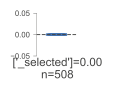

In [12]:
cs.create_lasso(flu_df, mode='explainer', label_col='is_flu', exclude_cols=['tcr_spec'], dtreeviz_plot=True, plot_name='Flu Epitope Clustering')

In [13]:
nonflu_means = df[df['cluster'] == 'not_flu'].select_dtypes(include='number').mean(axis=0)
cluster1_means_delta = df[df['cluster'] == 'flu_cluster1'].select_dtypes(include='number').mean(axis=0) - nonflu_means
cluster2_means_delta = df[df['cluster'] == 'flu_cluster2'].select_dtypes(include='number').mean(axis=0) - nonflu_means
cluster3_means_delta = df[df['cluster'] == 'flu_cluster3'].select_dtypes(include='number').mean(axis=0) - nonflu_means

In [14]:
means = pd.concat([cluster1_means_delta, cluster2_means_delta, cluster3_means_delta], 
                  axis=1)
means.columns = ['c1', 'c2', 'c3']

In [15]:
means.drop('tcr_spec', axis=0, inplace=True)

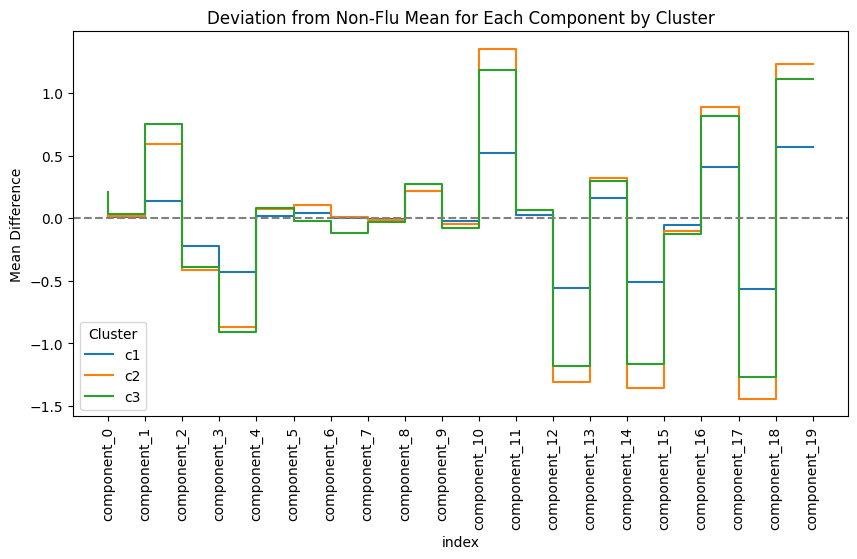

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unpivot the dataframe from wide to long format
means_melted = means.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Mean Difference')

# Plotting
plt.figure(figsize=(10, 5))
sns.lineplot(data=means_melted, x='index', y='Mean Difference', hue='Cluster', drawstyle='steps-pre')
plt.axhline(0, color='gray', linestyle='--')  # Add a line at y=0 for the baseline
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Deviation from Non-Flu Mean for Each Component by Cluster')
plt.show()

In [17]:
c1_delta = df[df['cluster'] == 'flu_cluster1'].select_dtypes(include='number') - nonflu_means
c2_delta = df[df['cluster'] == 'flu_cluster2'].select_dtypes(include='number') - nonflu_means
c3_delta = df[df['cluster'] == 'flu_cluster3'].select_dtypes(include='number') - nonflu_means

In [18]:
c2_delta

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,tcr_spec
19,0.058167,0.018648,0.591439,-0.411899,-0.866462,0.070818,0.105716,0.007558,-0.017773,0.21389,...,1.350964,0.068037,-1.310147,0.323173,-1.354847,-0.099749,0.890474,-1.444486,1.233705,-33.774658


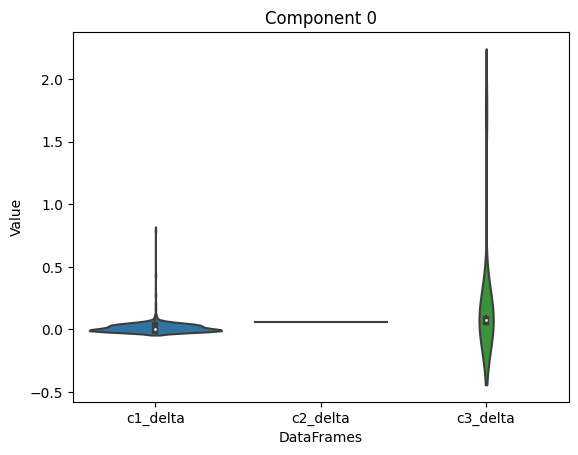

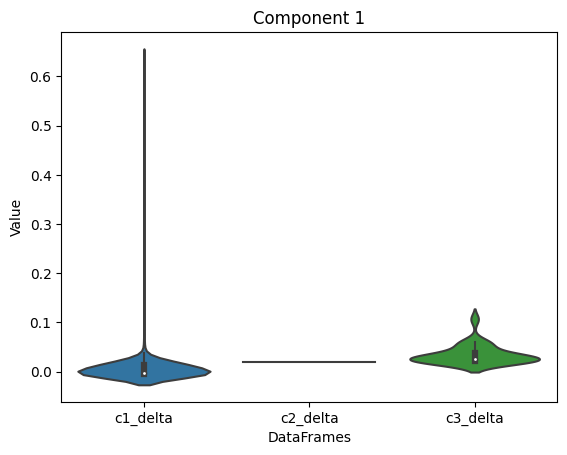

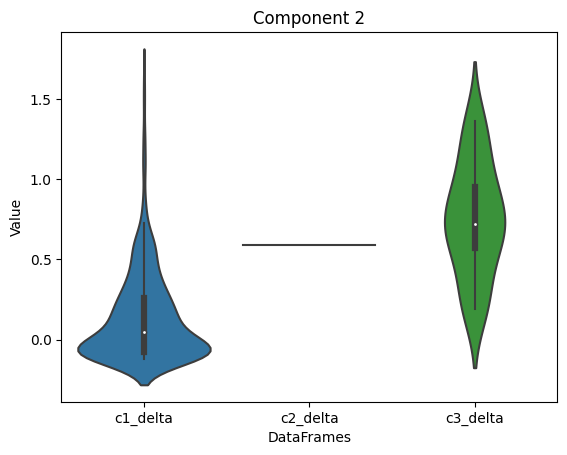

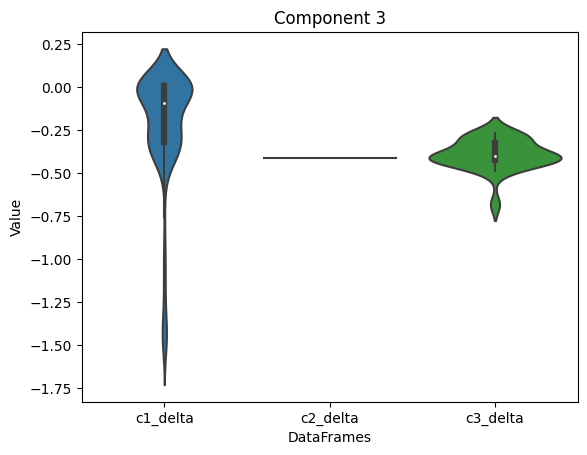

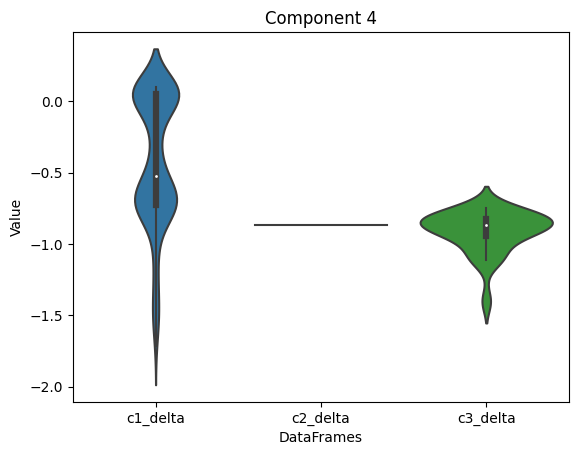

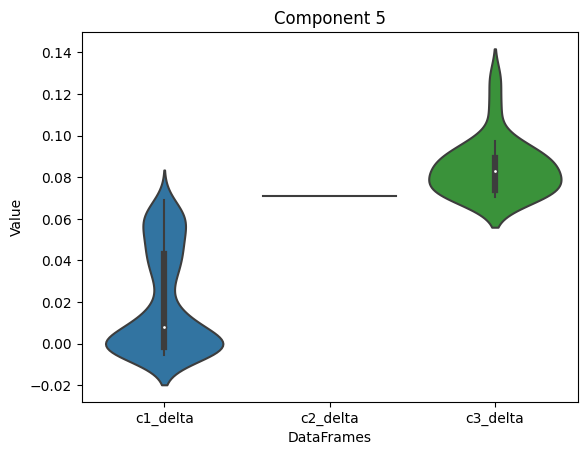

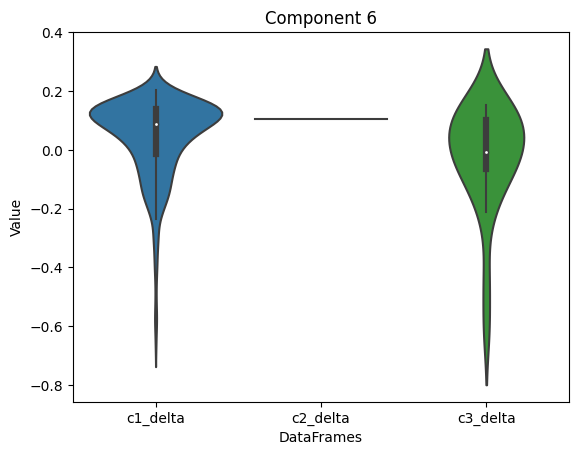

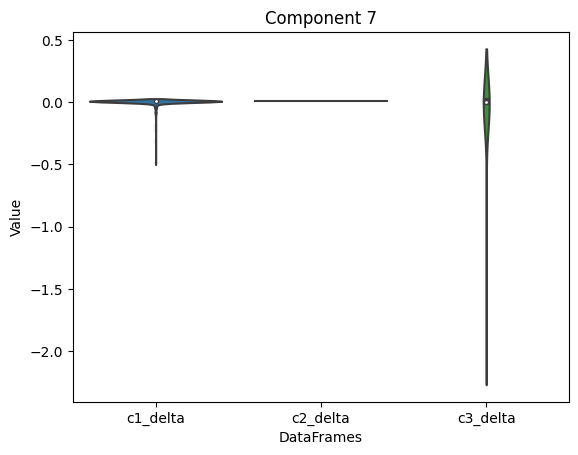

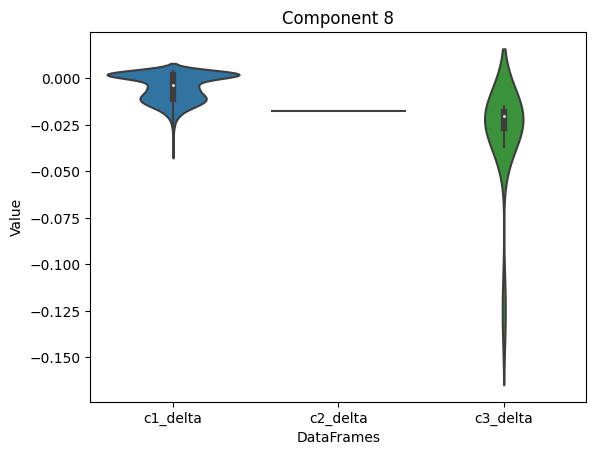

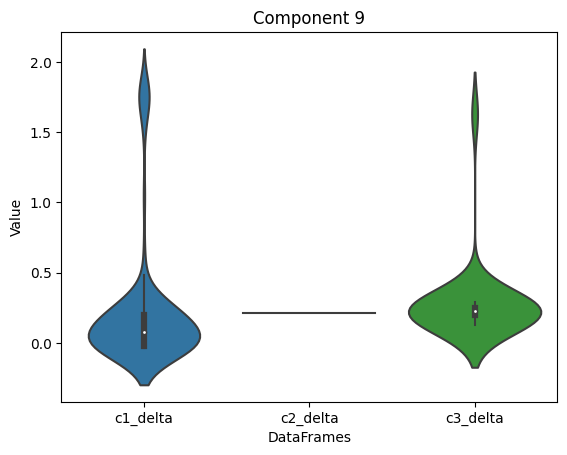

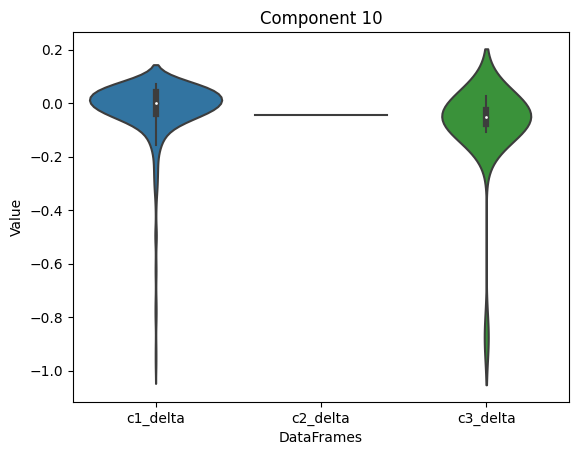

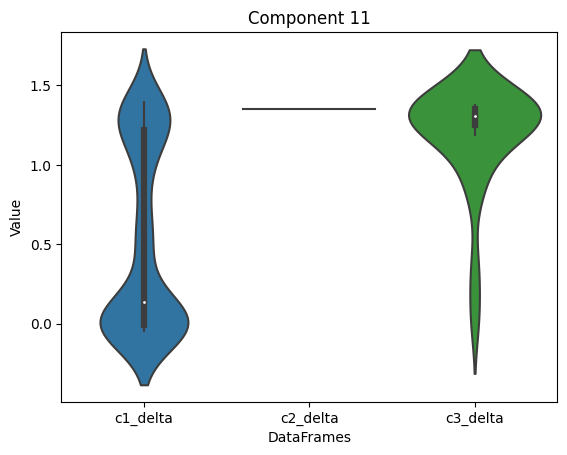

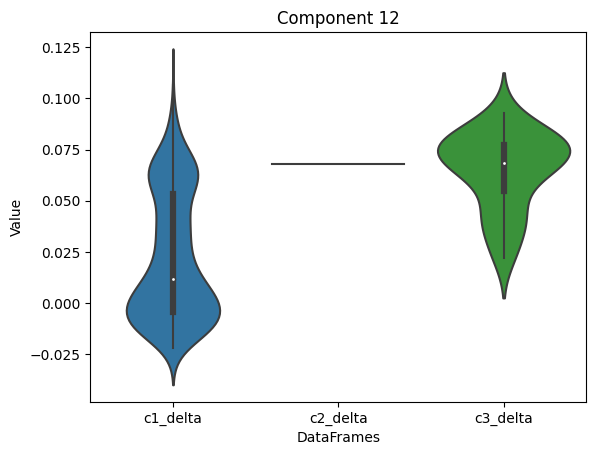

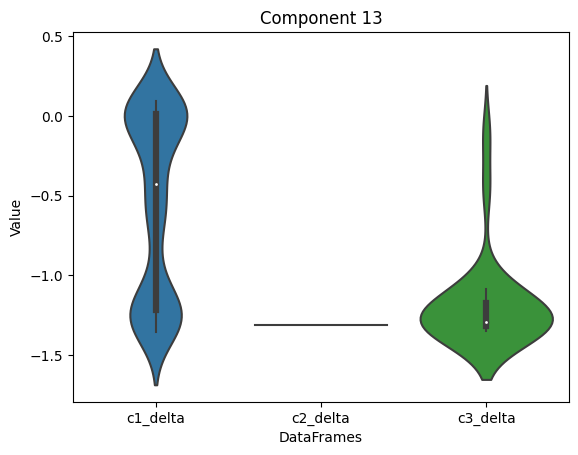

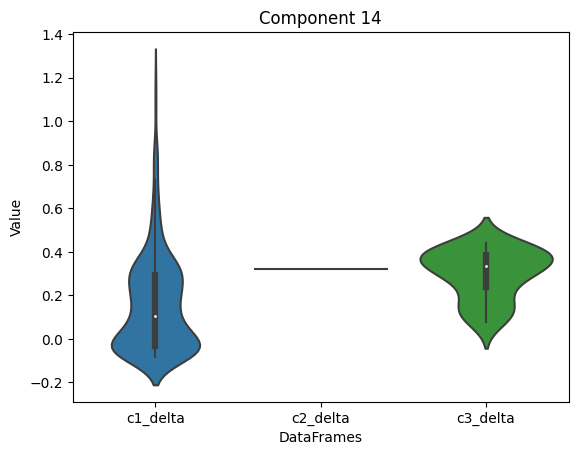

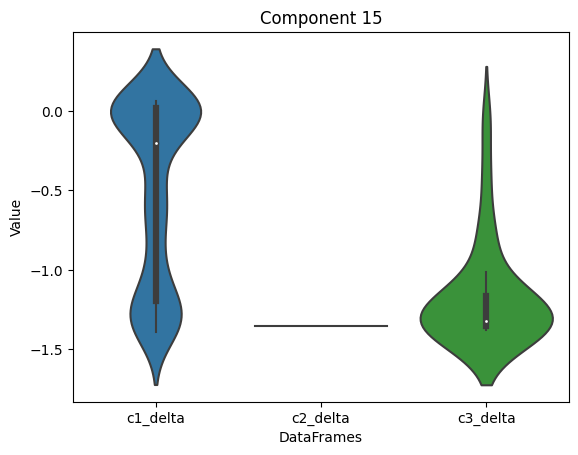

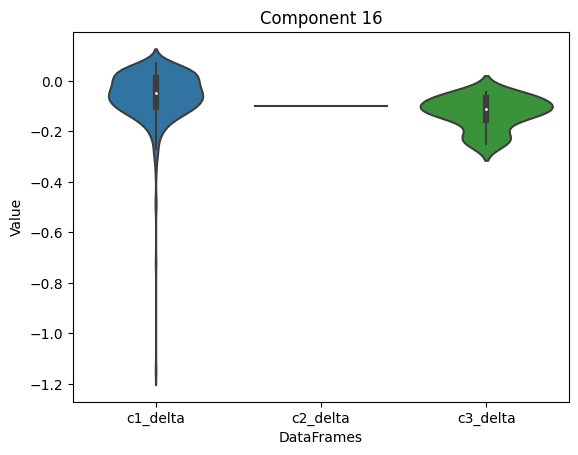

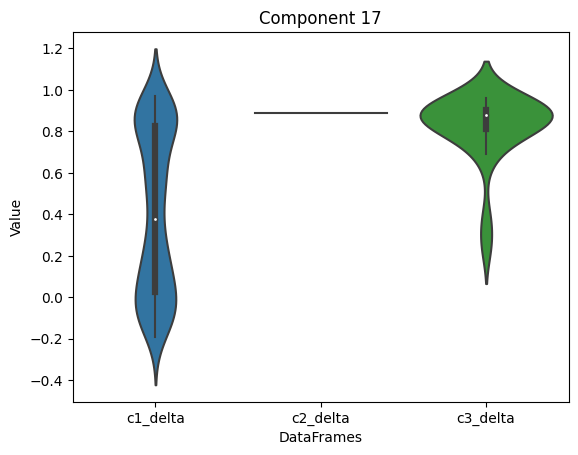

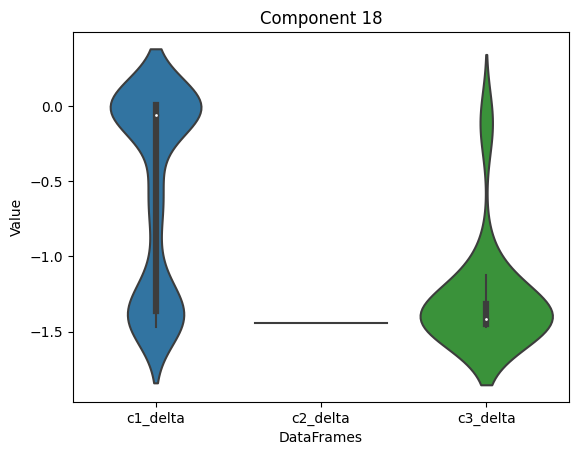

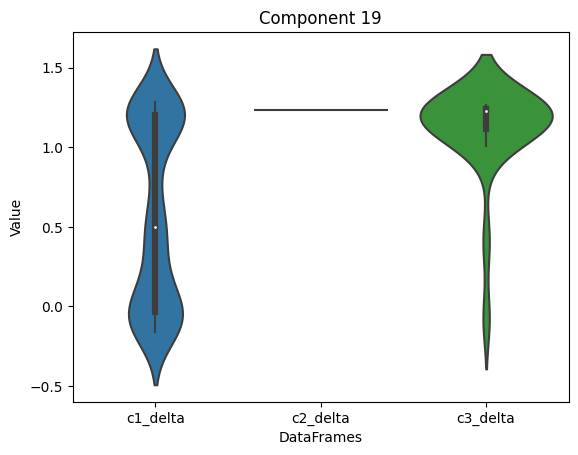

In [43]:
# Concatenate the three DataFrames vertically
combined_df = pd.concat([c1_delta, c2_delta, c3_delta], ignore_index=True)

# Create a new column to indicate the source DataFrame
combined_df['Source'] = ['c1_delta'] * len(c1_delta) + ['c2_delta'] * len(c2_delta) + ['c3_delta'] * len(c3_delta)

for i in range(0, 20):
    # Plot the violin plot
    sns.violinplot(data=combined_df, x='Source', y=f'component_{i}')

    # Set the plot title and labels
    plt.title(f'Component {i}')
    plt.xlabel('DataFrames')
    plt.ylabel('Value')

    # Show the plot
    plt.show()